In [1]:
import pandas as pd
import json
import nltk
from bs4 import BeautifulSoup
import re
import numpy as np
from sklearn import linear_model, \
            feature_extraction, preprocessing, metrics, ensemble
import matplotlib.pyplot as plt
import scipy

np.set_printoptions(precision=4)

%matplotlib inline 

Run the following once

In [2]:
#nltk.download("punkt", "stopwords")

In [3]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

In [4]:
print(nltk.__version__)

3.2.5


In [5]:
!head -n 1 /data/imdb-comments.json

{"label":"test","sentiment":"pos","name":"0_10.txt","content":"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."}


In [6]:
data = []
with open("/data/imdb-comments.json", "r", encoding="utf8") as f:
    for l in f.readlines():
        data.append(json.loads(l))    

In [7]:
comments = pd.DataFrame.from_dict(data)
comments.sample(10)

,content,label,name,sentiment
44814,A squashy slapstick mess posing as a comedy. E...,train,5333_4.txt,neg
13529,This conglomeration fails so miserably on ever...,test,10927_1.txt,neg
46942,"This movie rivals ""Plan 9"" as one of the dumbe...",train,7249_1.txt,neg
43532,"I get to the cinema every week or so, and regu...",train,417_1.txt,neg
26987,This might be the WWE's 2nd best PPV of the ye...,train,1178_10.txt,pos
21689,"This movie was so awful, so boring, so badly m...",test,7020_1.txt,neg
17675,Solange is not a great Italian thriller. Get r...,test,3408_4.txt,neg
22839,I'm probably one of the few people who defend ...,test,8056_2.txt,neg
18708,Don't pay any attention to the rave reviews of...,test,4338_1.txt,neg
17550,A stupid show in the vein of the rest of them ...,test,3296_1.txt,neg


In [8]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
content      50000 non-null object
label        50000 non-null object
name         50000 non-null object
sentiment    50000 non-null object
dtypes: object(4)
memory usage: 1.5+ MB


In [9]:
comments.label.value_counts()

train    25000
test     25000
Name: label, dtype: int64

In [10]:
comments.groupby(["label", "sentiment"]).content.count().unstack()

sentiment,neg,pos
label,,
test,12500,12500
train,12500,12500


In [11]:
np.random.seed(1)
v = list(comments["content"].sample(1))[0]
v

'When we started watching this series on cable, I had no idea how addictive it would be. Even when you hate a character, you hold back because they are so beautifully developed, you can almost understand why they react to frustration, fear, greed or temptation the way they do. It\'s almost as if the viewer is experiencing one of Christopher\'s learning curves.<br /><br />I can\'t understand why Adriana would put up with Christopher\'s abuse of her, verbally, physically and emotionally, but I just have to read the newspaper to see how many women can and do tolerate such behavior. Carmella has a dream house, endless supply of expensive things, but I\'m sure she would give it up for a loving and faithful husband - or maybe not. That\'s why I watch.<br /><br />It doesn\'t matter how many times you watch an episode, you can find something you missed the first five times. We even watch episodes out of sequence (watch season 1 on late night with commercials but all the language, A&E with lang

In [12]:
def preprocess(text):
    text = BeautifulSoup(text, "html5lib").text.lower() #removed html tags
    text = re.sub(r"[\W]+", " ", text)
    return text

preprocess(v)

'when we started watching this series on cable i had no idea how addictive it would be even when you hate a character you hold back because they are so beautifully developed you can almost understand why they react to frustration fear greed or temptation the way they do it s almost as if the viewer is experiencing one of christopher s learning curves i can t understand why adriana would put up with christopher s abuse of her verbally physically and emotionally but i just have to read the newspaper to see how many women can and do tolerate such behavior carmella has a dream house endless supply of expensive things but i m sure she would give it up for a loving and faithful husband or maybe not that s why i watch it doesn t matter how many times you watch an episode you can find something you missed the first five times we even watch episodes out of sequence watch season 1 on late night with commercials but all the language a e with language censored reruns on the movie network whenever 

In [13]:
%%time
comments["content"] = comments["content"].apply(preprocess)

CPU times: user 1min 21s, sys: 418 ms, total: 1min 22s
Wall time: 1min 22s


In [14]:
comments_train = comments[comments["label"] == "train"]
comments_train.sample(10)

,content,label,name,sentiment
25496,there are many people in our lives that we mee...,train,10447_10.txt,pos
41520,sixth escapade for freddy krueger in which he ...,train,2369_4.txt,neg
48525,the first few minutes of the bodyguard do have...,train,8674_2.txt,neg
26037,after reviewing this intense martial arts movi...,train,10934_10.txt,pos
43823,triumph of love is proof that not every coméd...,train,4441_3.txt,neg
39666,this is without a doubt the worst movie i have...,train,11950_2.txt,neg
40882,i had the opportunity to preview this film as ...,train,1795_2.txt,neg
43156,roeg has done some great movies but this a tur...,train,3841_1.txt,neg
37185,possible spoiler in some way how to alienate f...,train,9718_7.txt,pos
40330,sogo ishii can be a skilled filmmaker under th...,train,1298_3.txt,neg


In [15]:
comments_test = comments[comments["label"] == "test"]
comments_test.sample(10)

,content,label,name,sentiment
21277,this is one of those movies where i was rootin...,test,6650_1.txt,neg
12620,spoilersi m going to be as kind as i can about...,test,10108_1.txt,neg
4485,as a former erasmus student i enjoyed this fil...,test,2788_9.txt,pos
4744,francis ford coppola s masterpiece was a great...,test,301_10.txt,pos
10329,some of the reviewers here have foolishly judg...,test,8047_10.txt,pos
14366,this is by far one of the most pretentious fil...,test,11680_1.txt,neg
1007,this is truly a funny movie his dance scene do...,test,10907_8.txt,pos
4539,this film released in 1951 has the usual eleme...,test,2836_8.txt,pos
7864,one of the best tv shows out there if not the ...,test,5829_10.txt,pos
19582,this movie was jerry bruckheimer s idea to sel...,test,5124_4.txt,neg


In [16]:
X_train = comments_train["content"].values
y_train = np.where(comments_train.sentiment == "pos", 1, 0)

In [17]:
X_test = comments_test["content"].values
y_test = np.where(comments_test.sentiment == "pos", 1, 0)

In [18]:
# http://snowball.tartarus.org/algorithms/porter/stemmer.html
porter = nltk.stem.porter.PorterStemmer()
for s in "revival allowance inference relational".split():
    print(s, porter.stem(s))

revival reviv
allowance allow
inference infer
relational relat


In [19]:
def my_tokenizer(s):
    terms = [porter.stem(w) for w in nltk.word_tokenize(s)]
    terms = [term for term in terms if len(term) > 2]
    return terms 
my_tokenizer("The sun is shining. Allowance")

['the', 'sun', 'shine', 'allow']

In [20]:
stop = nltk.corpus.stopwords.words("english")
tfidf = feature_extraction.text.TfidfVectorizer(tokenizer=my_tokenizer, 
                    ngram_range=(1, 1), stop_words = stop)

docs = ["The sun is shining allowance", 
        "The weather is sweet", 
        "the sun is shining and the weather is sweet"]
doc_term_matrix = tfidf.fit_transform(docs)
print("TFIDF matrix: \n", doc_term_matrix.toarray())
print("Vocabulary: ", tfidf.vocabulary_) 
print("Type of doc_term_matrix", type(doc_term_matrix))
# returns term and index in the feature matrix

TFIDF matrix: 
 [[ 0.6809  0.5179  0.5179  0.      0.    ]
 [ 0.      0.      0.      0.7071  0.7071]
 [ 0.      0.5     0.5     0.5     0.5   ]]
Vocabulary:  {'sun': 2, 'shine': 1, 'allow': 0, 'weather': 4, 'sweet': 3}
Type of doc_term_matrix <class 'scipy.sparse.csr.csr_matrix'>


In [21]:
%%time
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

CPU times: user 4min 36s, sys: 1.27 s, total: 4min 37s
Wall time: 4min 40s


In [22]:
X_test_tfidf.shape, y_test.shape, X_train_tfidf.shape, y_train.shape

((25000, 51575), (25000,), (25000, 51575), (25000,))

Let's estimate the memory requirment if the data is presented in dense matrix format

In [23]:
cell_count = X_test_tfidf.shape[0] * X_test_tfidf.shape[1]
bytes = cell_count * 4 
GBs = bytes / (1024 ** 3) 
GBs

4.8032961785793304

In [24]:
sparsity = 1 - X_train_tfidf.count_nonzero() / cell_count
sparsity

0.9981450679592826

In [25]:
1 - X_train_tfidf.nnz / cell_count

0.9981450679592826

# Important terms for a document 

In [26]:
doc_index = 0
terms = pd.DataFrame({"term": pd.Series(tfidf.vocabulary_), 
    "avg_score": np.array(scipy.sparse.csc_matrix.mean(X_train_tfidf, 
                                    axis=0))[doc_index, :]})
terms= terms.reset_index()
terms = terms.sort_values("avg_score", ascending = False)
del terms["term"]
print("Total important terms", terms.shape[0])
terms.head(10)

Total important terms 51575


,index,avg_score
45462,thi,0.059450
30504,movi,0.056073
16323,film,0.046674
32618,one,0.027810
26512,like,0.025316
18848,good,0.021175
49581,watch,0.021125
45789,time,0.020271
48770,veri,0.019545
40066,see,0.019145


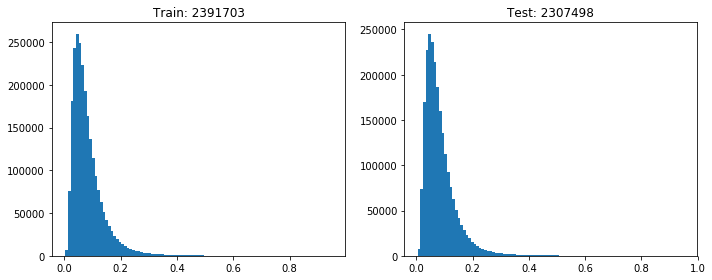

In [27]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(X_train_tfidf.data, bins = 100);
plt.title("Train: %d" % (len(X_train_tfidf.data)))
plt.subplot(1, 2, 2)
plt.hist(X_test_tfidf.data, bins = 100)
plt.title("Test: %d" % (len(X_test_tfidf.data)))
plt.tight_layout()

In [28]:
%%time
lr = linear_model.LogisticRegression(C = 1, 
                random_state = 0, n_jobs = 8, solver="saga")
lr.fit(X_train_tfidf, y_train)
y_test_pred = lr.predict(X_test_tfidf)
print("accuracy: ", metrics.accuracy_score(y_test, y_test_pred))

accuracy:  0.87848
CPU times: user 944 ms, sys: 12.5 ms, total: 956 ms
Wall time: 957 ms


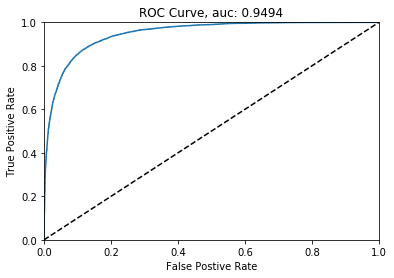

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr.predict_proba(X_test_tfidf)[:, [1]])
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1], [0,1], ls = "--", color = "k")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve, auc: %.4f" % auc);

In [30]:
%%time
from sklearn.naive_bayes import MultinomialNB
bayes = MultinomialNB(alpha=1)
bayes.fit(X_train_tfidf, y_train)
print("accuracy: ", bayes.score(X_test_tfidf, y_test))

accuracy:  0.8224
CPU times: user 42.3 ms, sys: 4.57 ms, total: 46.8 ms
Wall time: 45.3 ms
